In [1]:
import pyvisa
from PIL import Image
from IPython.display import display
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

rm = pyvisa.ResourceManager()
rm.list_resources()

inst = rm.open_resource('TCPIP::192.168.23.150::INSTR')
print(inst.query("*IDN?"))

RIGOL TECHNOLOGIES,MSO5072,MS5A210700340,00.01.03.03.00



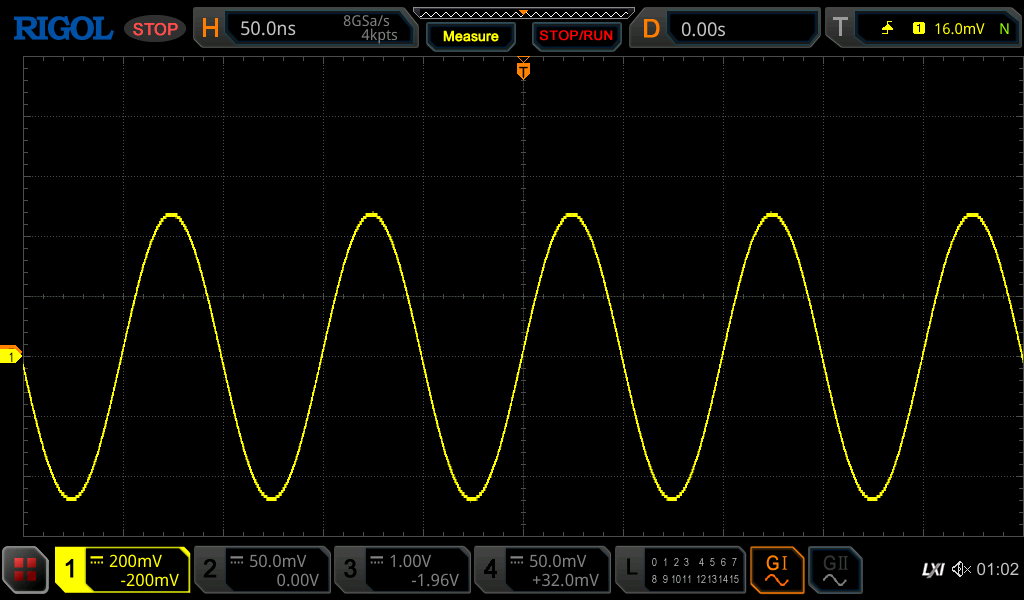

In [2]:
file_name = f'rigol_screen_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.bmp'
image_data = inst.query_binary_values(':DISPlay:DATA?', datatype='B', header_fmt='ieee', container=bytes)
with open(file_name, 'wb') as f:
    f.write(image_data)

display(Image.open(file_name))

Setup the instrument for downloading waveform data from channel 1

In [3]:
inst.write(':WAVeform:SOURce CHANnel1')
inst.write(':WAVeform:MODE RAW')
inst.write(':WAVeform:FORMat BYTE')
inst.write(':WAVeform:POINts RAW')

22

In [4]:
# Instrument must be stopped to read out all mem
inst.write(':STOP')
# Get the raw memory points
inst.write(':WAV:DATA?')
wav_data = inst.read_raw()
# Get the scaling factors for time and voltage
x_incr = float(inst.query(':WAVeform:XINCrement?'))
y_incr = float(inst.query(':WAVeform:YINCrement?'))
y_offset = float(inst.query(':WAVeform:YORigin?'))

# Remove the header and tail byte from the Rigol message array, convert to numpy array for easy proccessing
wav_data_np = np.frombuffer(wav_data, dtype=np.uint8)[11:-1]
# Perform the scaling and create a time vector for plotting
scaled_wav = (wav_data_np.astype(np.float64) - 128 - y_offset) * y_incr
t_wav = np.arange(len(scaled_wav)) * x_incr

capture_dt = datetime.now()

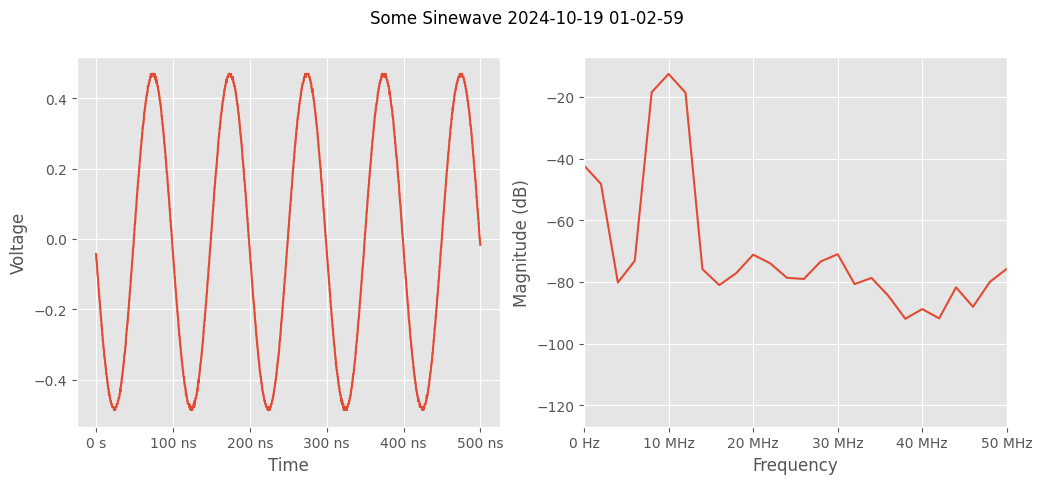

In [5]:
# Some plotting of the scope data

from matplotlib.ticker import EngFormatter

plt.style.use('ggplot')
fig, ax = plt.subplots(nrows=1, ncols=2)

# Plot the time series
ax[0].xaxis.set_major_formatter(EngFormatter(unit='s'))
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Voltage')
ax[0].plot(t_wav, scaled_wav)

# Plot the magnitude freq spectrum
ax[1].xaxis.set_major_formatter(EngFormatter(unit='Hz'))
ax[1].magnitude_spectrum(scaled_wav, Fs=1/x_incr, scale='dB')
ax[1].set_xlim(0, 50E6)

fig.suptitle(f'Some Sinewave {capture_dt.strftime('%Y-%m-%d %H-%M-%S')}')
fig.set_figwidth(12)
plt.show()

